In [1]:
from torch.distributions.uniform import Uniform

from main import train_and_eval, train_loader, test_loader

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch

### Visualize training and testing data

In [2]:
for x in train_loader:
    break
    
for y in test_loader:
    break
    
x.size(), y.size()

(torch.Size([128, 1, 20, 20]), torch.Size([128, 1, 20, 20]))

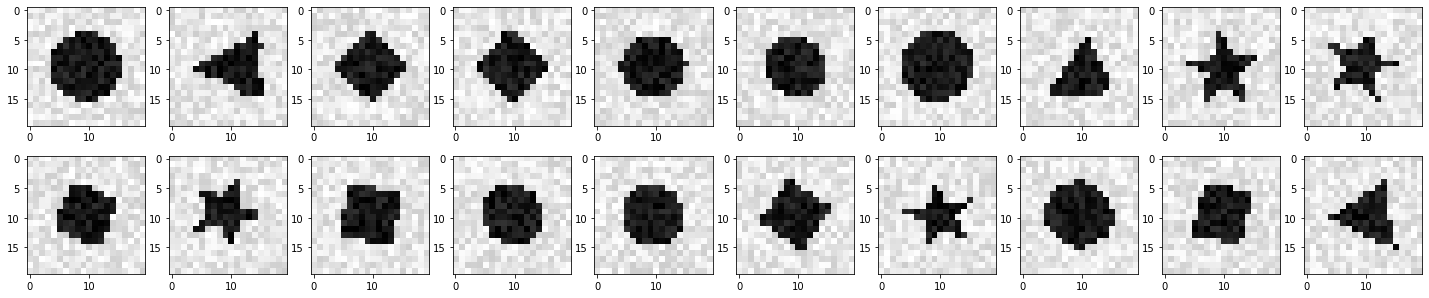

In [3]:
_, axes = plt.subplots(2,10,figsize=(25,5))
for i in range(10):
    axes[0][i].imshow(x[i].squeeze().numpy(), 'gray')
    axes[1][i].imshow(y[i].squeeze().numpy(), 'gray')

### Train the flow model

In [ ]:
target_distribution = Uniform(0,1)
flow, train_losses, test_losses = train_and_eval(10, 1e-3, train_loader, test_loader, target_distribution)

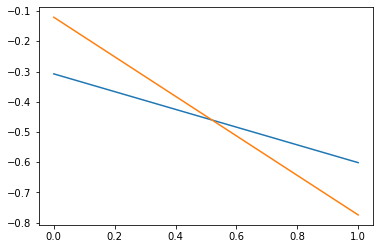

In [6]:
_ = plt.plot(train_losses)
_ = plt.plot(test_losses)

### Sample from the trained model

In [21]:
a = torch.randn(4,6)
a[[0,1,2], [3,4,5]]

tensor([1.0089, 0.2505, 0.1919])

In [18]:
torch.multinomial(torch.randn(4,5).softmax(1), 1)

tensor([[2],
        [1],
        [4],
        [0]])

In [34]:
from torch.distributions.normal import Normal

def sample(flow, num_samples):
    n_channels, height, width = 1, 20, 20
    result = torch.zeros(num_samples, n_channels, height, width)
    with torch.no_grad():
        for row in range(height):
            for col in range(width):
                for channel in range(n_channels):
                    model_output = flow.model(result)
                    mus, log_sigmas, weight_logits = torch.chunk(model_output, 3, dim=1)
                    
                    mus = mus.view(num_samples, flow.n_components, n_channels, height, width)
                    log_sigmas = log_sigmas.view(num_samples, flow.n_components, n_channels, height, width)
                    weight_logits = weight_logits.view(num_samples, flow.n_components, n_channels, height, width)
                    
                    # get the mus, sigmas and weights for pixel at (channel, row, col)
                    mus = mus[:,:,channel, row, col]
                    log_sigmas = log_sigmas[:,:,channel, row, col]
                    weight_logits = weight_logits[:,:,channel, row, col]
                    weights = weight_logits.softmax(dim=1)
                    
                    # a sample at (channel, row, col) comes from a mixture of Gaussians
                    # where the probability of the Gaussian `i` is given by `weights[i]`
                    indices_of_gaussians_to_sample_from = torch.multinomial(weights, 1).squeeze(-1)
                    zero_to_num_samples = torch.arange(num_samples)
                    mus_per_batch = mus[zero_to_num_samples, indices_of_gaussians_to_sample_from]
                    sigmas_per_batch = log_sigmas[zero_to_num_samples, indices_of_gaussians_to_sample_from].exp()
                    result[:, channel, row, col] = torch.normal(mus_per_batch, sigmas_per_batch)
    return result

In [52]:
out = sample(flow, 10)

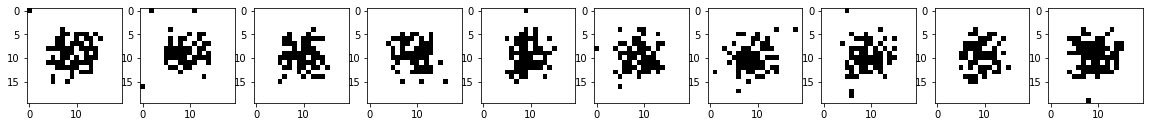

In [53]:
_, axes = plt.subplots(1,10,figsize=(20,5))

for i in range(10):
    _ = axes[i].imshow((out[i].squeeze().numpy() > 0.375).astype(np.float32), 'gray')